In [1]:
import os
import numpy as np
import pandas as pd
from astropy.coordinates import Angle
import astropy.units as u
from tess_stars2px import tess_stars2px_function_entry
import tessreduce as tr

/Users/wendysun/Desktop/QPE_TESS_2025summer/stats/lib/python3.13/site-packages/lightkurve/prf/__init__.py:7: UserWarning: Warning: the tpfmodel submodule is not available without oktopus installed, which requires a current version of autograd. See #1452 for details.
  warnings.warn(
/Users/wendysun/Desktop/QPE_TESS_2025summer/stats/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Read data from TNS
df = pd.read_csv('data/tns_search_tde.csv')

In [3]:
def get_coords(df):
    # Convert RA & DEC to degrees
    ra_deg = df['RA'].apply(lambda x: Angle(x, unit=u.hourangle).degree)
    dec_deg = df['DEC'].apply(lambda x: Angle(x, unit=u.deg).degree)
    coords_deg = list(zip(ra_deg, dec_deg))
    return coords_deg

In [6]:
def tess_reduce(coords_deg, name, sector, adjust_coords=False):
    for ra, dec in coords_deg:
        print(f"\nRA: {ra:.6f}, DEC: {dec:.6f}")
        # TESS point
        ticid = 0 # code doesn't actually use ticid
        print('outID outSec outCam outCcd outColPix outRowPix')
        outID, outEclipLong, outEclipLat, outSec, outCam, outCcd, outColPix, outRowPix, scinfo = tess_stars2px_function_entry(ticid, ra, dec)
        for i in range(len(outID)):
            if outSec[i] != sector:
                continue
            print('{0:d} {1:d} {2:d} {3:d} {4:f} {5:f}'.format(outID[i], outSec[i], outCam[i], outCcd[i], outColPix[i], outRowPix[i]))
            # TESS reduce
            if adjust_coords:
                ra = ra + 0.02
                dec = dec + 0.02
            tess = tr.tessreduce(ra=ra, dec=dec, sector=outSec[i], savename=f'data/plots/{name}/ra{ra}_dec{dec}_sec{outSec[i]}', parallel=True)
            if tess.lc is None:
                tess = tr.tessreduce(ra=ra, dec=dec, sector=outSec[i], savename=f'data/plots/{name}/ra{ra}_dec{dec}_sec{outSec[i]}', parallel=False)
            return tess


RA: 105.048108, DEC: -66.040039
outID outSec outCam outCcd outColPix outRowPix
0 63 4 2 155.740420 796.597555
getting TPF from TESScut
made reference
!!!WARNING!!! mask is too dense, lowering mask_scale to 0.5, and raising maglim to 15. Background quality will be reduced.
made source mask
calculating background
background subtracted
aligning images
!!! skernel 1095
!!Re-running for difference image!!
shifting images
remade mask
background
background correlation correction
field calibration
target is below -30 dec, calibrating to SkyMapper photometry.


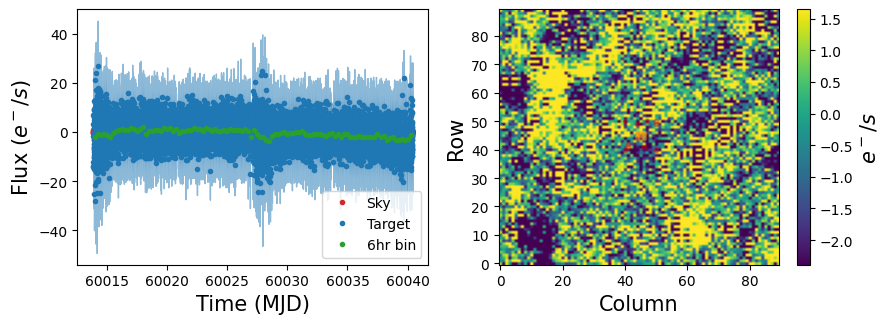

In [7]:
name19 = '2019ahk'
df19 = df[(df['Redshift'] < 0.03) & (df['Name'] == f'TDE {name19}')]
coords19 = get_coords(df19)
tess_original = tess_reduce(coords19, name19, sector=63, adjust_coords=True)

(10942, 90, 90)


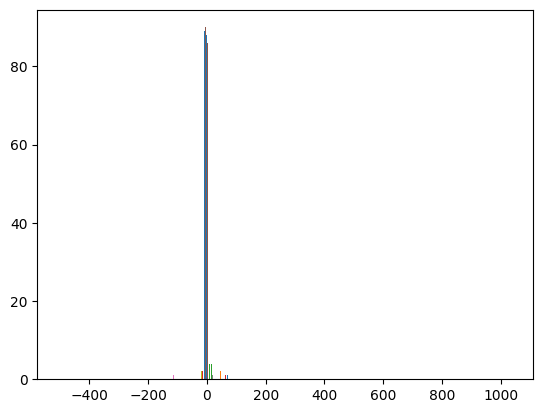

3483
3393
3.7014406961259074
-3.226467812658202


In [16]:
print(tess_original.flux.shape)
# Make a histogram of the flux
import matplotlib.pyplot as plt
plt.hist(tess_original.flux[3000], bins=100)
plt.show()
# Print the x-index of the max and min flux
print(np.argmax(tess_original.flux[3000]))
print(np.argmin(tess_original.flux[3000]))
# print the x-index of the highest 5% and lowest 5% of flux
print(np.percentile(tess_original.flux[3000], 95))
print(np.percentile(tess_original.flux[3000], 5))


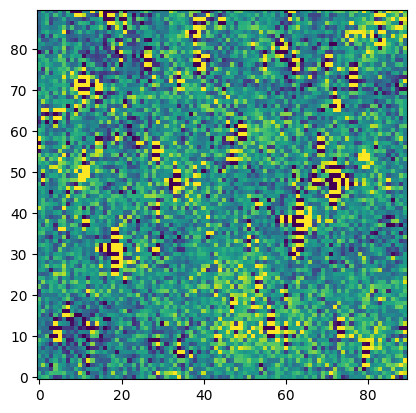

In [17]:
plt.figure()
plt.imshow(tess_original.flux[3000],vmax=4,vmin=-4,origin='lower')

In [21]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.patches import Circle

def make_animation(tess):
    frames = tess.flux
    # Subsample: keep only every 3rd frame
    frames_sub = frames[::3]
    n_sub = len(frames_sub)
    fig, ax = plt.subplots()
    im = ax.imshow(
        frames_sub[0],
        origin='lower',
        vmin=-4,
        vmax=4,
        cmap='viridis'
    )
    ax.set_title("TESS Flux Frame 0 (subsampled)")

    # Determine image dimensions and center coordinates in data/pixel space
    img_height, img_width = frames_sub[0].shape
    x_center = img_width / 2.0
    y_center = img_height / 2.0

    # Create a small circle at the center (radius=5 pixels, no fill, white edge)
    circle = Circle(
        (x_center, y_center),
        radius=5,
        edgecolor='red',    # changed to red
        facecolor='none',
        linewidth=1.5,
        zorder=2
    )
    ax.add_patch(circle)

    def update(i):
        im.set_array(frames_sub[i])
        ax.set_title(f"TESS Flux Frame {i*3}")  # show original index if you like
        return (im,)

    ani = animation.FuncAnimation(
        fig,
        update,
        frames=range(n_sub),
        interval=50,
        blit=True
    )

    ani.save(
        'tess_flux_animation.mp4',
        writer='ffmpeg',
        fps=100,
        dpi=150
    )
    plt.close(fig)
    print("Saved tess_flux_animation_sub3.mp4")


RA: 136.357833, DEC: 61.802550
outID outSec outCam outCcd outColPix outRowPix
0 74 1 4 257.297479 1294.698147
getting TPF from TESScut
made reference


/Users/wendysun/Desktop/QPE_TESS_2025summer/stats/lib/python3.13/site-packages/lightkurve/prf/__init__.py:7: UserWarning: Warning: the tpfmodel submodule is not available without oktopus installed, which requires a current version of autograd. See #1452 for details.
  warnings.warn(


made source mask
calculating background


/Users/wendysun/Desktop/QPE_TESS_2025summer/stats/lib/python3.13/site-packages/lightkurve/prf/__init__.py:7: UserWarning: Warning: the tpfmodel submodule is not available without oktopus installed, which requires a current version of autograd. See #1452 for details.
  warnings.warn(
/Users/wendysun/Desktop/QPE_TESS_2025summer/stats/lib/python3.13/site-packages/lightkurve/prf/__init__.py:7: UserWarning: Warning: the tpfmodel submodule is not available without oktopus installed, which requires a current version of autograd. See #1452 for details.
  warnings.warn(
/Users/wendysun/Desktop/QPE_TESS_2025summer/stats/lib/python3.13/site-packages/lightkurve/prf/__init__.py:7: UserWarning: Warning: the tpfmodel submodule is not available without oktopus installed, which requires a current version of autograd. See #1452 for details.
  warnings.warn(
/Users/wendysun/Desktop/QPE_TESS_2025summer/stats/lib/python3.13/site-packages/lightkurve/prf/__init__.py:7: UserWarning: Warning: the tpfmodel subm

background subtracted
aligning images
!!! skernel 1031
!!Re-running for difference image!!
shifting images
remade mask
background
background correlation correction
field calibration
target is above -30 dec, calibrating to PS1 photometry.


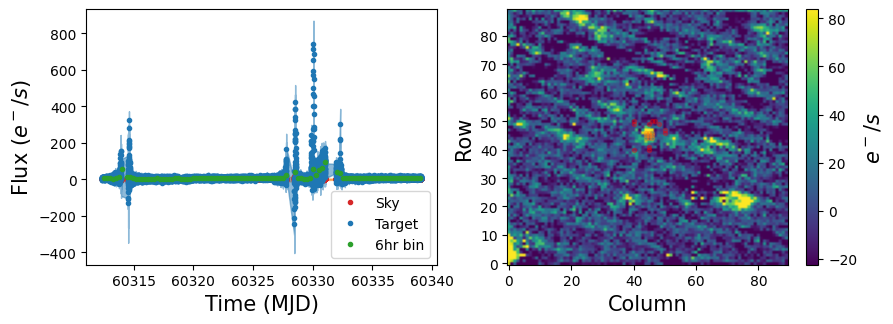

In [20]:
name20 = '2020wey'
df20 = df[(df['Redshift'] < 0.03) & (df['Name'] == f'TDE {name20}')]
coords20 = get_coords(df20)
tess20 = tess_reduce(coords20, name20, sector=74)

In [29]:
make_animation(tess20)

Saved tess_flux_animation_sub3.mp4


In [22]:
make_animation(tess_original)

Saved tess_flux_animation_sub3.mp4
